In [1]:
# Importation des librairies de base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import wrds

In [2]:
# Connexion à la base de données WRDS
db = wrds.Connection(wrds_username='lilas_bertot')

# Changer le nom après wrds_username pour te connecter, 
# entrer le nom d'utilisateur puis ton mot de passe dans la barre du haut, 
# puis "y" pour ne pas avoir à te reconnecter à chaque fois!

Loading library list...
Done


In [3]:
# Extraction efficace des données CRSP

# Liste des symboles d'actions
stocks = ['V', 'LNC', 'LPLA', 'VRSN', 'LRCX', 'LOGI', 'VLO', 'LYB', 'DVN']
stocks_str = "', '".join(stocks)


stock_query = f"""
SELECT a.date, b.ticker, a.permno, a.ret, a.prc, a.shrout, a.vol,
        a.bid, a.ask
FROM crsp.dsf a
INNER JOIN crsp.dsenames b ON a.permno = b.permno
WHERE b.ticker IN ('{stocks_str}')
AND a.date >= '2011-01-01' 
AND a.date <= '2024-12-31'
AND a.date >= b.namedt 
AND a.date <= b.nameendt
ORDER BY b.ticker, a.date
"""

stock_data_filtered = db.raw_sql(stock_query, date_cols=['date'])

for stock in stocks:
    stock_count = len(stock_data_filtered[stock_data_filtered['ticker'] == stock])
    print(f"{stock}: {stock_count} observations")

V: 3522 observations
LNC: 3522 observations
LPLA: 3522 observations
VRSN: 3522 observations
LRCX: 3522 observations
LOGI: 3522 observations
VLO: 3522 observations
LYB: 3522 observations
DVN: 3522 observations


In [4]:
# Aperçu des données
stock_data_filtered.info()
stock_data_filtered


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31698 entries, 0 to 31697
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    31698 non-null  datetime64[ns]
 1   ticker  31698 non-null  string        
 2   permno  31698 non-null  Int64         
 3   ret     31698 non-null  Float64       
 4   prc     31698 non-null  Float64       
 5   shrout  31698 non-null  Float64       
 6   vol     31698 non-null  Float64       
 7   bid     31698 non-null  Float64       
 8   ask     31698 non-null  Float64       
dtypes: Float64(6), Int64(1), datetime64[ns](1), string(1)
memory usage: 2.4 MB


,date,ticker,permno,ret,prc,shrout,vol,bid,ask
0,2011-01-03,DVN,87137,0.002165,78.68,431900.0,2557300.0,78.63,78.64
1,2011-01-04,DVN,87137,-0.006101,78.2,431900.0,2875800.0,78.16,78.17
2,2011-01-05,DVN,87137,0.006394,78.7,431900.0,2885000.0,78.69,78.71
3,2011-01-06,DVN,87137,-0.005972,78.23,431900.0,2462300.0,78.24,78.25
4,2011-01-07,DVN,87137,0.00294,78.46,431900.0,1830900.0,78.47,78.49
...,...,...,...,...,...,...,...,...,...
31693,2024-12-24,VRSN,85753,0.007601,201.48,96100.0,215237.0,201.32001,201.48
31694,2024-12-26,VRSN,85753,0.006204,202.73,96100.0,365131.0,202.62,202.71001
31695,2024-12-27,VRSN,85753,0.006018,203.95,96100.0,564782.0,203.92999,204.03
31696,2024-12-30,VRSN,85753,0.005639,205.10001,96100.0,890432.0,205.08,205.17999


In [5]:
# Extraction efficace des données SPX
print("🔍 Exécution de la requête SQL pour SPX...")

spx_query = """
SELECT date, spindx as prc
FROM crsp.dsi 
WHERE date >= '2011-01-01' 
AND date <= '2024-12-31'
AND spindx IS NOT NULL
ORDER BY date
"""

spx_data = db.raw_sql(spx_query, date_cols=['date'])

# Calcul des rendements
spx_data = spx_data.sort_values('date')
spx_data['ret'] = spx_data['prc'].pct_change()

spx_data.info()
spx_data

🔍 Exécution de la requête SQL pour SPX...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3522 entries, 0 to 3521
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3522 non-null   datetime64[ns]
 1   prc     3522 non-null   Float64       
 2   ret     3521 non-null   Float64       
dtypes: Float64(2), datetime64[ns](1)
memory usage: 89.6 KB


,date,prc,ret
0,2011-01-03,1271.87,<NA>
1,2011-01-04,1270.2,-0.001313
2,2011-01-05,1276.56,0.005007
3,2011-01-06,1273.85,-0.002123
4,2011-01-07,1271.5,-0.001845
...,...,...,...
3517,2024-12-24,6040.04,0.011043
3518,2024-12-26,6037.59,-0.000406
3519,2024-12-27,5970.84,-0.011056
3520,2024-12-30,5906.94,-0.010702


In [11]:
# 3 janvier 2012 au 3 janvier 2023
start_date = '2012-01-03'
end_date = '2023-01-03'

#Quels titres on analyse - LNC (Lincoln National - Financier), LRCX (Lam Research - Technologie), LYB (LyondellBasell - Énergie)
titles_to_analyze = {
    'SPX': spx_data[(spx_data['date'] >= start_date) & (spx_data['date'] <= end_date)],
    'LNC': stock_data_filtered[(stock_data_filtered['ticker'] == 'LNC') & 
                               (stock_data_filtered['date'] >= start_date) & 
                               (stock_data_filtered['date'] <= end_date)],
    'LRCX': stock_data_filtered[(stock_data_filtered['ticker'] == 'LRCX') & 
                                (stock_data_filtered['date'] >= start_date) & 
                                (stock_data_filtered['date'] <= end_date)],
    'LYB': stock_data_filtered[(stock_data_filtered['ticker'] == 'LYB') & 
                               (stock_data_filtered['date'] >= start_date) & 
                               (stock_data_filtered['date'] <= end_date)]
}

Analyse de SPX
Statistiques descriptives des rendements :
count      2769.0
mean     0.000461
std      0.010842
min     -0.119841
25%     -0.003702
50%      0.000582
75%      0.005369
max      0.093828
Name: ret, dtype: Float64


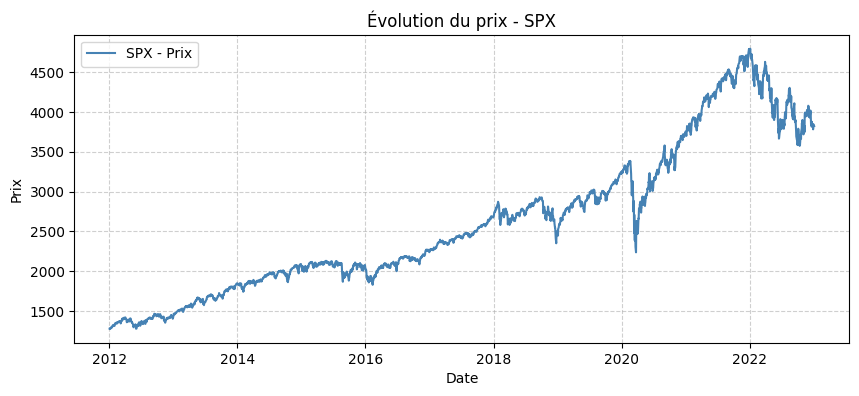

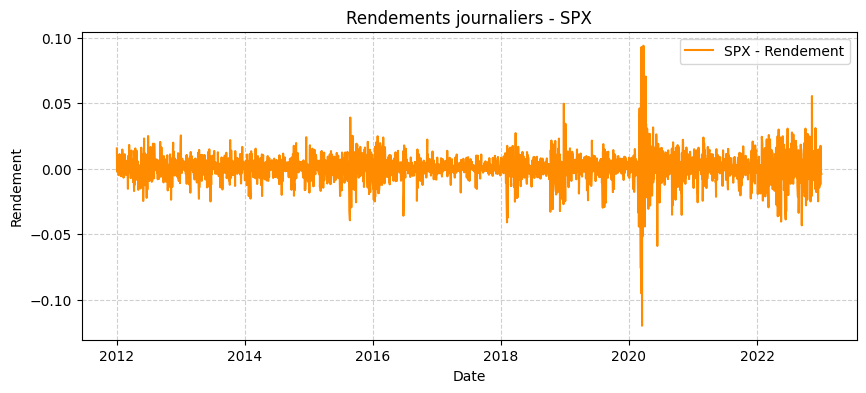

Analyse de LNC
Statistiques descriptives des rendements :
count      2769.0
mean     0.000629
std      0.027164
min     -0.331478
25%     -0.010658
50%      0.000964
75%      0.012797
max      0.317003
Name: ret, dtype: Float64


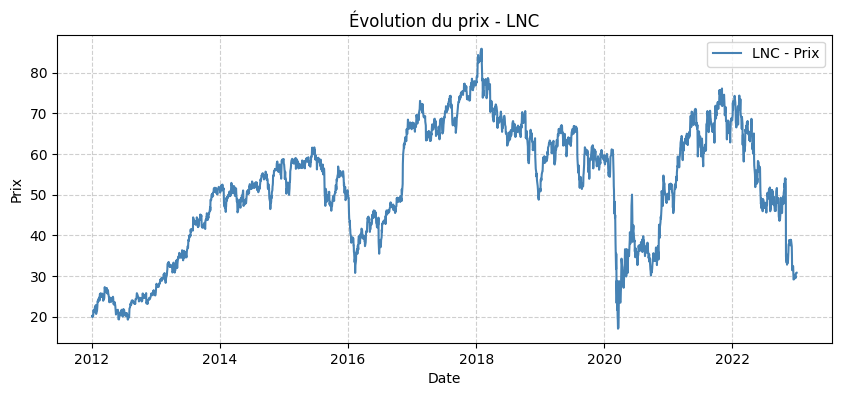

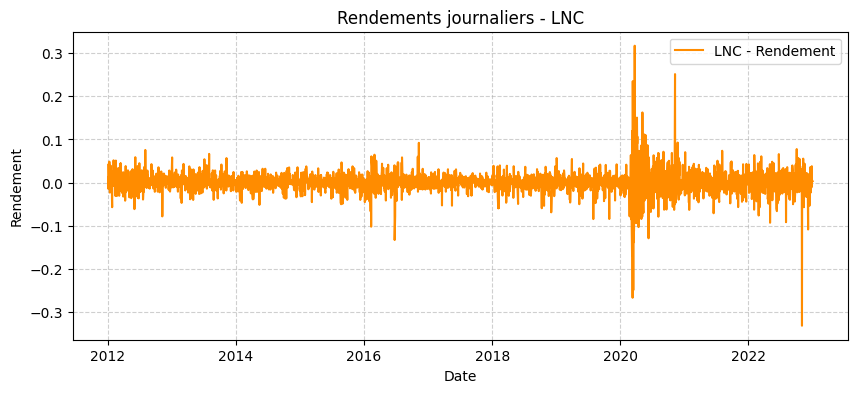

Analyse de LRCX
Statistiques descriptives des rendements :
count      2769.0
mean     0.001211
std      0.024158
min     -0.184277
25%     -0.010666
50%      0.001142
75%      0.013074
max      0.201919
Name: ret, dtype: Float64


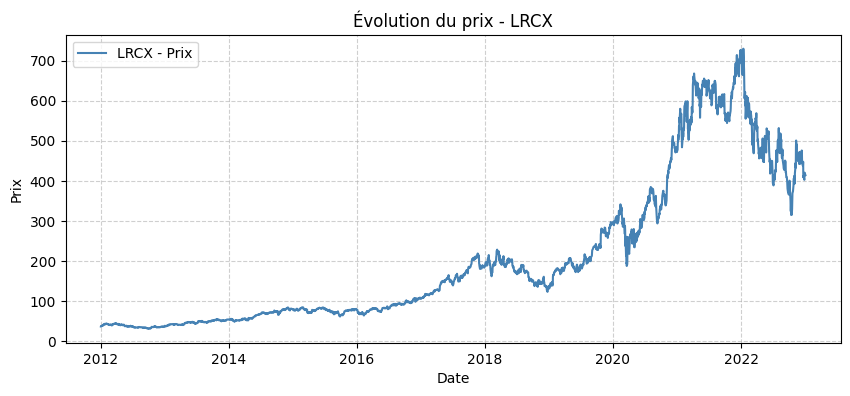

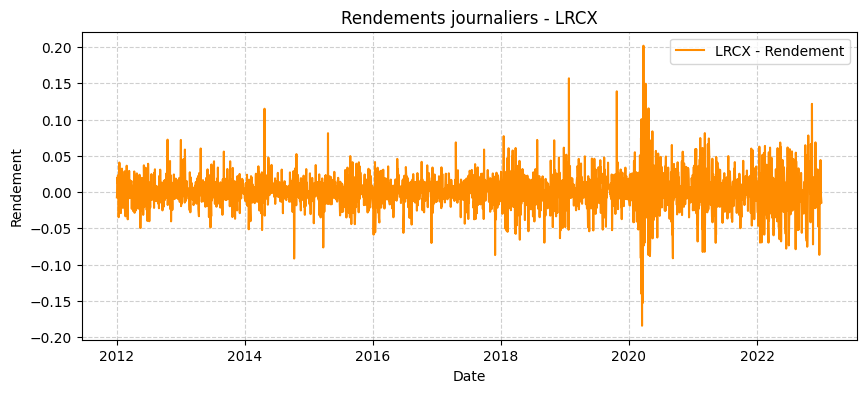

Analyse de LYB
Statistiques descriptives des rendements :
count      2769.0
mean     0.000788
std       0.02213
min      -0.25491
25%     -0.009726
50%      0.000619
75%       0.01149
max      0.195415
Name: ret, dtype: Float64


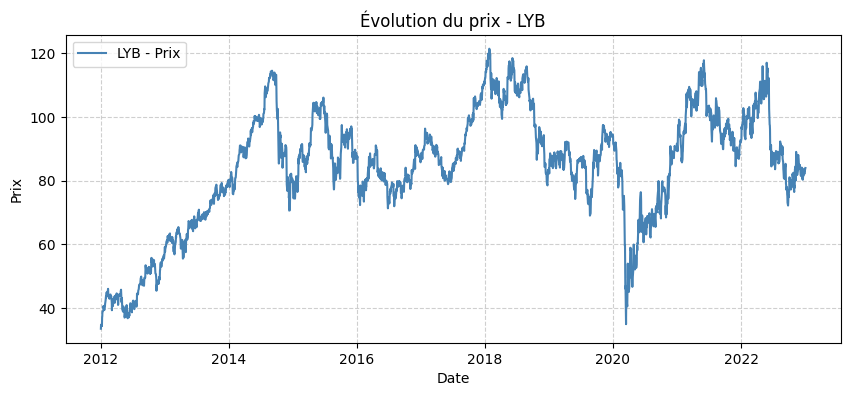

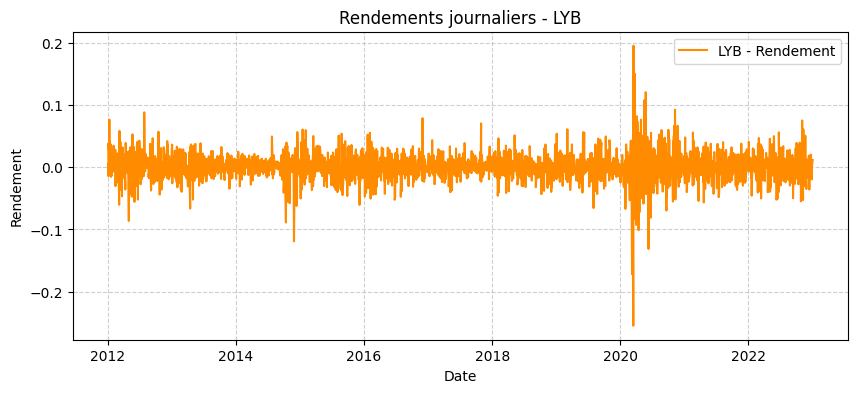

In [12]:
def analyze_title(name, df):
    print(f"Analyse de {name}")

    # données triées par date
    df = df.sort_values('date')

    # Statistiques descriptives
    print("Statistiques descriptives des rendements :")
    print(df['ret'].describe())

    # Série chronologique prix 
    plt.figure(figsize=(10, 4))
    plt.plot(df['date'], df['prc'], label=f'{name} - Prix', color='steelblue')
    plt.title(f"Évolution du prix - {name}")
    plt.xlabel('Date')
    plt.ylabel('Prix')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

    # Rendements 
    plt.figure(figsize=(10, 4))
    plt.plot(df['date'], df['ret'], label=f'{name} - Rendement', color='darkorange')
    plt.title(f"Rendements journaliers - {name}")
    plt.xlabel('Date')
    plt.ylabel('Rendement')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

# analyse complète pour chaque titre
for name, df in titles_to_analyze.items():
    analyze_title(name, df)

In [14]:
# Quels titres on analyse - uniquement SPX et actions techno+énergie
titles_for_var = {
    'SPX': titles_to_analyze['SPX'],
    'LRCX': titles_to_analyze['LRCX'],
    'LYB': titles_to_analyze['LYB']  
}